## Open Vaccine Stanford GRU Model - RNA Covid 19

**mRNA vaccines** have taken the lead as the fastest vaccine candidates for COVID-19, but currently, they face key potential limitations. One of the biggest challenges right now is **how to design super stable messenger RNA molecules (mRNA)**. 

Conventional vaccines (like your seasonal flu shots) are packaged in disposable syringes and shipped under refrigeration around the world, but that is not currently possible for mRNA vaccines.

**Ribonucleic acid (RNA)** is a linear molecule composed of four types of smaller molecules called ribonucleotide bases: adenine (A), cytosine (C), guanine (G), and uracil (U).

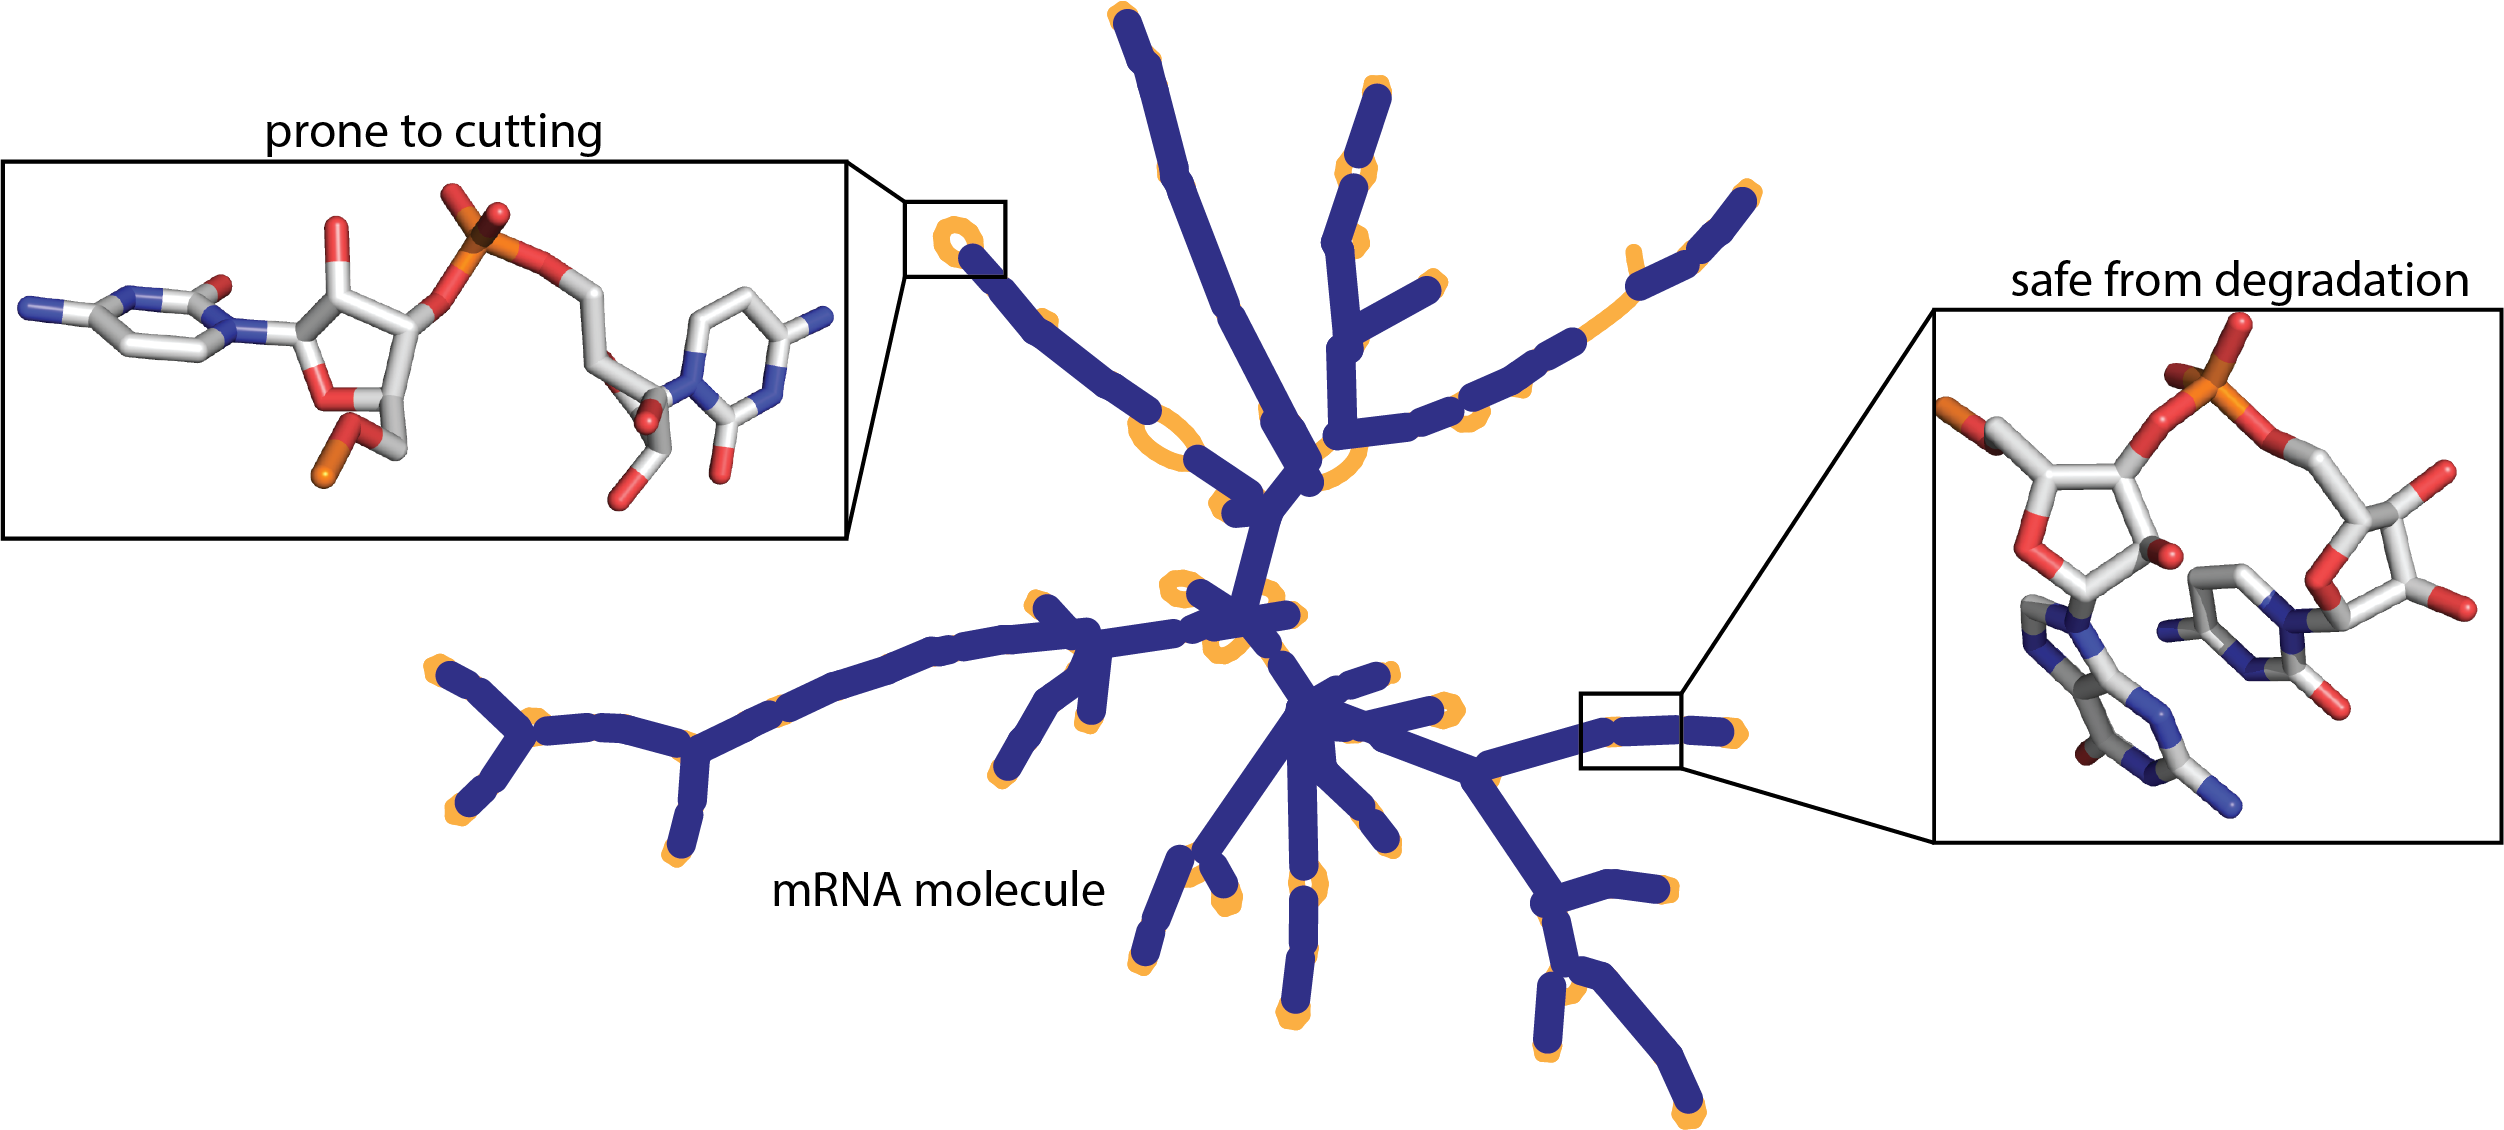
Each ribonucleotide base consists of a ribose sugar, a phosphate group, and a nitrogenous base .


Researchers have observed that RNA molecules have the tendency to **spontaneously degrade**. This is a serious limitation--a single cut can render the mRNA vaccine useless. Currently, little is known on the details of where in the backbone of a given RNA is most prone to being affected. Without this knowledge, current mRNA vaccines against COVID-19 must be prepared and shipped under intense refrigeration, and are unlikely to reach more than a tiny fraction of human beings on the planet unless they can be stabilized.

**Task:** To build a model which will predict likely degradation rates at each base of an RNA molecule which can be useful To develop models and design rules for RNA degradation.  




https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

**Sequence Prediction**

Sequence prediction is a problem that involves using historical sequence information to predict the next value or values in the sequence. The sequence may be symbols like letters in a sentence or real values like those in a time series of prices

**GRU**

The GRU, known as the Gated Recurrent Unit is an RNN architecture, which is similar to LSTM units. The GRU comprises of the reset gate and the update gate instead of the input, output and forget gate of the LSTM.

**Bidirectional RNNs**

In a bidirectional RNN, we consider 2 separate sequences. One from right to left and the other in the reverse order.

**Bidirectional Gated Recurrent Unit (GRU)**

Bidirectional GRU's are a type of bidirectional recurrent neural networks with only the reset and update gates. It allows for the use of information from both previous time steps and later time steps to make predictions about the current state.




In [90]:
import json
import pandas as pd
import numpy as np
import plotly.express as px
import tensorflow.keras.layers as L
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [91]:
#set seeds to ensure reproducibility
tf.random.set_seed(2020)
np.random.seed(2020)

##Load Data



In [92]:
#load data
data = pd.read_json('data.json', lines=True)
data.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [134]:
#info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

## Data Description

**sequence** - (1x107 string) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).

**structure** - (1x107 string) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.

**predicted_loop_type** - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

**reactivity** - (1x68 vector) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.

**deg_pH10** - (1x68 vector) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).

**deg_Mg_pH10** - (1x68 vector) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).

**deg_50C** - (1x68 vector) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).

**deg_Mg_50C** - (1x68 vector) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).




## Visualizing Distribution of Structure Molecules, Sequences and Predicted Loop Type

In [93]:
#convert X to list
from functools import reduce
all_structures = reduce(lambda x, y: x + y, data['structure'].apply(list).tolist())
all_sequences = reduce(lambda x, y: x + y, data['sequence'].apply(list).tolist())
all_predicted_loop_types = reduce(lambda x, y: x + y, data['predicted_loop_type'].apply(list).tolist())

In [94]:
print(len(all_structures))
print(len(all_sequences))
print(len(all_predicted_loop_types))

256800
256800
256800


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



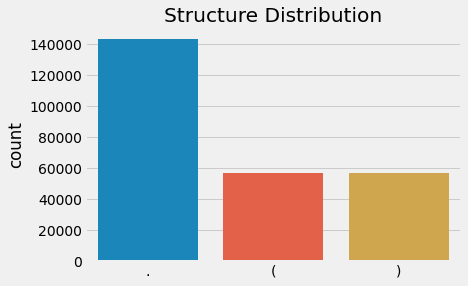

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



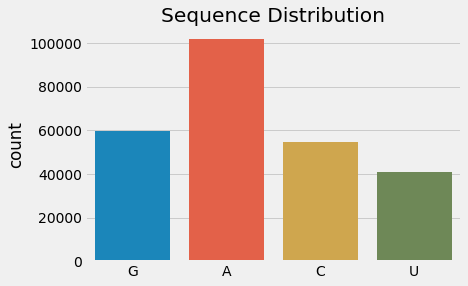

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



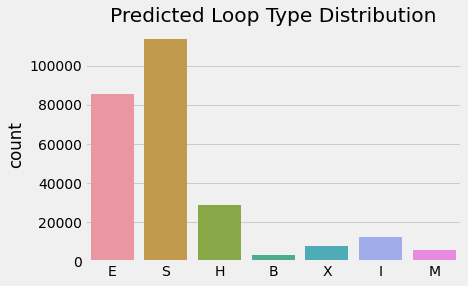

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot
plt.title('Structure Distribution')
sns.countplot(all_structures)
plt.show()

plt.title('Sequence Distribution')
sns.countplot(all_sequences)
plt.show()

plt.title('Predicted Loop Type Distribution')
sns.countplot(all_predicted_loop_types)
plt.show()

#Plotting Average Reactivity at each Position 

In [96]:
plt.style.use('fivethirtyeight')

avg_reactivity = np.array(list(map(np.array, data.reactivity))).mean(axis=0)
avg_deg_50C = np.array(list(map(np.array, data.deg_50C))).mean(axis=0)
avg_deg_pH10 = np.array(list(map(np.array, data.deg_pH10))).mean(axis=0)
avg_deg_Mg_50C = np.array(list(map(np.array, data.deg_Mg_50C))).mean(axis=0)
avg_deg_Mg_pH10 = np.array(list(map(np.array, data.deg_Mg_pH10))).mean(axis=0)

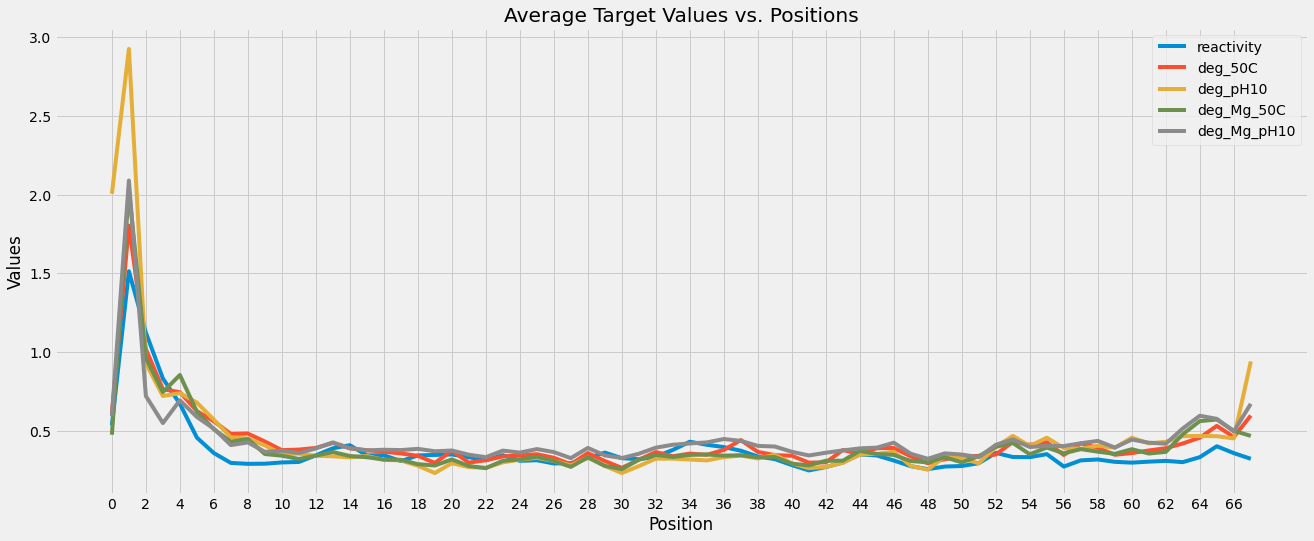

In [97]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=range(68), y=avg_reactivity, label='reactivity')
sns.lineplot(x=range(68), y=avg_deg_50C, label='deg_50C')
sns.lineplot(x=range(68), y=avg_deg_pH10, label='deg_pH10')
sns.lineplot(x=range(68), y=avg_deg_Mg_50C, label='deg_Mg_50C')
sns.lineplot(x=range(68), y=avg_deg_Mg_pH10, label='deg_Mg_pH10')

plt.xlabel('Position')
plt.xticks(range(0, 68, 2))
plt.ylabel('Values')
plt.title('Average Target Values vs. Positions')

plt.show()

##Data Preprocessing




In [98]:
for i in enumerate('().ACGUBEHIMSX'):
  print(i)

(0, '(')
(1, ')')
(2, '.')
(3, 'A')
(4, 'C')
(5, 'G')
(6, 'U')
(7, 'B')
(8, 'E')
(9, 'H')
(10, 'I')
(11, 'M')
(12, 'S')
(13, 'X')


In [99]:
#convert sequence to number
token2int = {x: i for i, x in enumerate('().ACGUBEHIMSX')}

In [100]:
#convert dataframe to numpy array 
def pandas_list_to_array(df):
  return np.transpose(np.array(df.values.tolist()), 
                      (0, 2, 1))

In [101]:
#preprocess inputs X
def preprocess_inputs(df, 
                      token2int,
                      cols=['sequence', 'structure', 'predicted_loop_type']):
  return pandas_list_to_array(df[cols].applymap(lambda seq: [token2int[x] for x in seq]))

In [102]:
#create columns for y
pred_cols = ['reactivity', 
             'deg_Mg_pH10',
             'deg_Mg_50C',
             'deg_pH10',
             'deg_50C']

In [103]:
#convert data into required format
data_inputs = preprocess_inputs(data, token2int)
data_labels = pandas_list_to_array(data[pred_cols])

In [104]:
#should be in array
data_inputs

array([[[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       ...,

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]],

       [[5, 2, 8],
        [5, 2, 8],
        [3, 2, 8],
        ...,
        [3, 2, 8],
        [3, 2, 8],
        [4, 2, 8]]])

In [105]:
data_labels

array([[[ 3.29700e-01,  7.55600e-01,  3.58100e-01,  2.33750e+00,
          6.38200e-01],
        [ 1.56930e+00,  2.98300e+00,  2.96830e+00,  3.50600e+00,
          3.47730e+00],
        [ 1.12270e+00,  2.52600e-01,  2.58900e-01,  3.00800e-01,
          9.98800e-01],
        ...,
        [ 2.93700e-01,  3.33600e-01,  4.81200e-01,  5.14200e-01,
          3.28700e-01],
        [ 2.36200e-01,  6.49100e-01,  7.02600e-01,  7.68100e-01,
          5.30100e-01],
        [ 5.73100e-01,  6.89800e-01,  4.25400e-01,  1.17200e+00,
          8.47200e-01]],

       [[ 0.00000e+00,  0.00000e+00,  4.85110e+00,  4.94700e+00,
          7.66920e+00],
        [ 0.00000e+00,  0.00000e+00,  4.04260e+00,  4.45230e+00,
          0.00000e+00],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          1.09561e+01],
        ...,
        [-1.26310e+00, -7.81700e-01,  1.34800e-01, -2.62440e+00,
         -3.19560e+00],
        [ 0.00000e+00,  0.00000e+00,  5.27300e-01,  1.06010e+00,
          0.00000

##Train Test Split

In [106]:
#train test split to get train and val set
X_train, X_val, y_train, y_val = train_test_split(data_inputs, data_labels,
                                                    test_size=0.25,
                                                    random_state=121,
                                                    stratify=data.SN_filter)

In [107]:
#check shape
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1800, 107, 3)
(600, 107, 3)
(1800, 68, 5)
(600, 68, 5)


In [108]:
#train test split to get train and test set
X_train, X_test, y_train, y_test = train_test_split(data_inputs, data_labels,
                                                    test_size=0.25,
                                                    random_state=121)

In [109]:
#check shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800, 107, 3)
(600, 107, 3)
(1800, 68, 5)
(600, 68, 5)


**MCRMSE**

Normally, we can calculate RMSE to get a single-number evaluation metric for our prediction, but if we are predicting multiple values at once, we need to predict degradation rates under multiple conditions, we would get multiple different RMSE values, one for each column.

The MCRMSE is simply an average across all RMSE values for each of our columns, so we can still use a single-number evaluation metric, even in the case of multiple outputs.

**Dense Layer**

The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer. The dense layer is found to be the most commonly used layer in the models.


In [110]:
def MCRMSE(y_true, y_pred):
  colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
  return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)

In [111]:
def gru_layer(hidden_dim, dropout):
  return L.Bidirectional(L.GRU(hidden_dim,
                               dropout=dropout,
                               return_sequences=True,
                               kernel_initializer='orthogonal'))

In [112]:
def build_model(embed_size, 
                seq_len=107,
                sp_dropout=0.2,
                n_layers=3,
                hidden_dim=256,
                pred_len=68,
                dropout=0.5):
  
  inputs = L.Input(shape=(seq_len, 3))

  embed = L.Embedding(input_dim=embed_size,
                      output_dim=200)(inputs)

  reshaped = tf.reshape(embed,
                      shape = (-1,
                               embed.shape[1],
                               embed.shape[2] * embed.shape[3]))
  
  hidden = L.SpatialDropout1D(sp_dropout)(reshaped)

  for x in range(n_layers):
    hidden = gru_layer(hidden_dim, dropout)(hidden)

  truncated = hidden[:, :pred_len]

  out = L.Dense(5, activation='linear')(truncated)

  model = tf.keras.Model(inputs=inputs,
                         outputs=out)
  
  model.compile(tf.optimizers.Adam(),
                loss=MCRMSE,
                metrics=['accuracy'])
  
  return model

In [113]:
#build model
model = build_model(embed_size=len(token2int))

In [114]:
#summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 107, 3)]          0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 107, 3, 200)       2800      
_________________________________________________________________
tf.reshape_2 (TFOpLambda)    (None, 107, 600)          0         
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 107, 600)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 107, 512)          1317888   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 107, 512)          1182720   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 107, 512)          1182

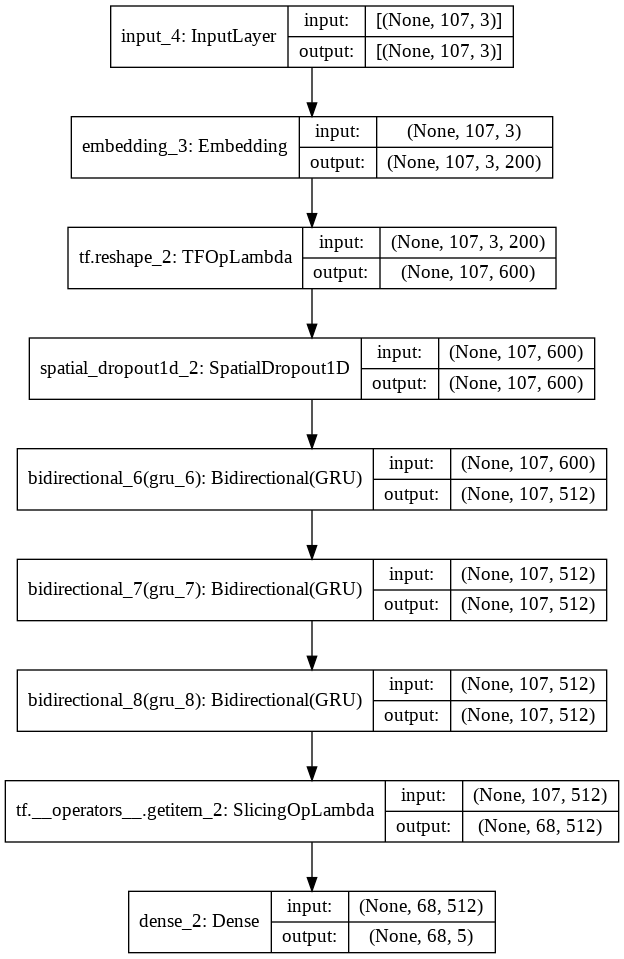

In [123]:
from keras.utils.vis_utils import plot_model

#plot
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

**Epoch** is once all images are processed one time individually of forward and backward to the network, then that is one epoch.

**Learning Rate**  

Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0. The learning rate controls how quickly the model is adapted to the problem.

**ReduceLROnPlateau**

Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.



In [115]:
#fit
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),
                               tf.keras.callbacks.ModelCheckpoint('model.h5')])

Epoch 1/100
29/29 - 19s - loss: 0.6022 - accuracy: 0.2812 - val_loss: 0.5468 - val_accuracy: 0.3193
Epoch 2/100
29/29 - 7s - loss: 0.5341 - accuracy: 0.3101 - val_loss: 0.5235 - val_accuracy: 0.3553
Epoch 3/100
29/29 - 7s - loss: 0.5121 - accuracy: 0.3413 - val_loss: 0.5033 - val_accuracy: 0.3447
Epoch 4/100
29/29 - 7s - loss: 0.4973 - accuracy: 0.3491 - val_loss: 0.4941 - val_accuracy: 0.3613
Epoch 5/100
29/29 - 7s - loss: 0.4877 - accuracy: 0.3560 - val_loss: 0.4915 - val_accuracy: 0.3761
Epoch 6/100
29/29 - 7s - loss: 0.4819 - accuracy: 0.3630 - val_loss: 0.4866 - val_accuracy: 0.3251
Epoch 7/100
29/29 - 7s - loss: 0.4774 - accuracy: 0.3646 - val_loss: 0.4714 - val_accuracy: 0.3997
Epoch 8/100
29/29 - 7s - loss: 0.4693 - accuracy: 0.3737 - val_loss: 0.4733 - val_accuracy: 0.3527
Epoch 9/100
29/29 - 7s - loss: 0.4663 - accuracy: 0.3741 - val_loss: 0.4635 - val_accuracy: 0.3760
Epoch 10/100
29/29 - 7s - loss: 0.4571 - accuracy: 0.3778 - val_loss: 0.4562 - val_accuracy: 0.4108
Epoch 11

##Plotting

The **History.history** attribute is a dictionary recording training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

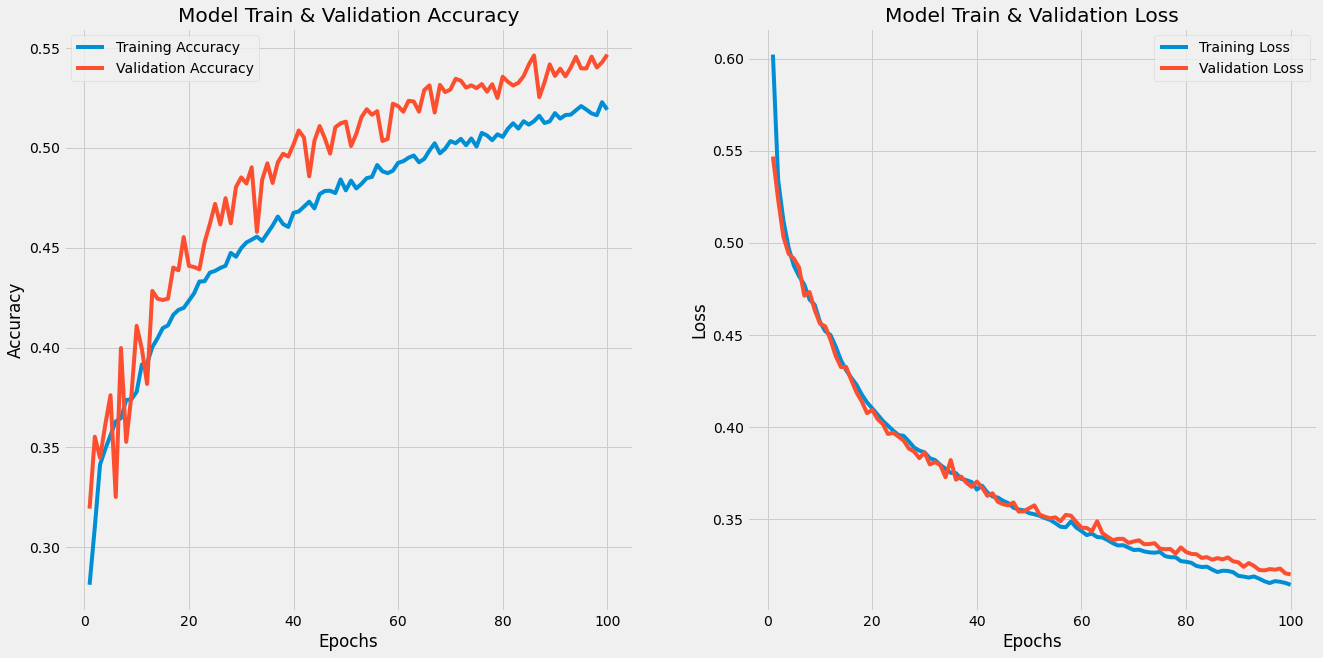

In [125]:
# plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , label = 'Training Loss')
ax[1].plot(epochs, val_loss , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

##Evaluation

Returns the loss value & metrics values for the model.

In [126]:
#evaluate
print('Train loss & accuracy:', model.evaluate(X_train, y_train, batch_size=64))
print('\n')
print('Test loss & accuracy:', model.evaluate(X_test, y_test, batch_size=64))

29/29 [==============================] - 3s 86ms/step - loss: 0.2929 - accuracy: 0.5595
Train loss & accuracy: [0.2928869426250458, 0.5594689249992371]


10/10 [==============================] - 1s 81ms/step - loss: 0.4172 - accuracy: 0.4869
Test loss & accuracy: [0.41722485423088074, 0.4869117736816406]


## Prediction

Generates output predictions for the input samples.


In [133]:
#predict
y_pred = model.predict(X_test)

In [130]:
#print predictions
print(y_pred.shape)
print(pd.DataFrame(y_pred[0]))

(600, 68, 5)
           0         1         2         3         4
0   0.513001  0.995335  0.651183  2.760782  0.991103
1   1.429461  1.868821  1.714310  3.193763  2.306451
2   1.205592  0.805244  1.006722  1.071974  1.201472
3   1.089023  0.803286  1.060582  1.023387  1.305723
4   0.937816  0.627667  0.787244  0.740853  0.955561
..       ...       ...       ...       ...       ...
63  0.209072  0.254256  0.335856  0.209785  0.320969
64  0.749796  2.162574  1.734813  0.799159  0.819583
65  0.702866  0.444798  0.610036  0.376147  0.431330
66  0.491459  0.319609  0.411492  0.321852  0.436525
67  0.212222  0.650175  0.561632  0.850663  0.505443

[68 rows x 5 columns]


In [131]:
def degradation_sample(index):
  #create columns for y
  original_cols = ['reactivity',
                   'deg_Mg_pH10',
                   'deg_Mg_50C',
                   'deg_pH10',
                   'deg_50C']
  pred_cols = ['reactivity_pred',
               'deg_Mg_pH10_pred',
               'deg_Mg_50C_pred',
               'deg_pH10_pred',
               'deg_50C_pred'] 

  predicted_df = pd.DataFrame(y_pred[index], columns=pred_cols)
  original_df = pd.DataFrame(y_test[index], columns=original_cols)
  orig_pred_df = pd.concat([original_df, predicted_df], axis=1)

  return orig_pred_df

In [132]:
#predict sample
degradation_sample(5)

,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C,reactivity_pred,deg_Mg_pH10_pred,deg_Mg_50C_pred,deg_pH10_pred,deg_50C_pred
0,0.4052,0.5738,0.3669,1.5113,0.4025,0.507845,0.488886,0.407527,1.913341,0.623493
1,1.3919,1.6362,1.8465,3.0137,1.3953,1.335419,1.938061,1.920731,3.312242,1.781513
2,1.2140,0.7708,1.0277,1.1635,1.7479,1.215258,0.846747,1.152742,1.193007,1.266576
3,0.9617,0.5794,1.0325,0.6215,0.9845,0.899382,0.555973,0.871012,0.733497,1.046144
4,0.2272,0.9163,1.1868,0.6811,0.7247,0.223875,0.762382,1.038588,0.693186,0.647044
...,...,...,...,...,...,...,...,...,...,...
63,0.0418,0.2702,0.1109,0.2171,0.1634,0.089023,0.265917,0.105751,0.177832,0.124195
64,0.0779,0.4200,0.3912,0.4321,0.2277,0.092522,0.590682,0.368176,0.497838,0.315555
65,1.3615,1.4741,1.0746,0.7698,0.4014,1.484191,1.588550,1.247833,1.203256,0.650145
66,1.1656,1.6756,1.0233,1.1149,0.8872,1.292260,1.809367,1.084757,1.398808,1.166958
